In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

 2023f_boar/                       Linear_Evaluation_Imagenet_Subset.ipynb
 20240114-145439resnet_simclr.h5   losses.py
 20240115-020017resnet_simclr.h5   mydata_SimCLR_ImageNet_Subset.ipynb
 20240116-091021resnet_simclr.h5   __pycache__/
 dataset_github用/                 Supervised_Full_Dataset.ipynb
 dataset_github用.zip              wandb/
 helpers.py                       '実装 のコピー'


## Initial setup

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
!nvidia-smi

Tue Jan 16 10:15:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb

In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: Currently logged in as: ojus. Use `wandb login --relogin` to force relogin


True

### Restoring model weights from GCS Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration-411216"
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
!gsutil cp gs://resnet_simclr_imagenet/20240116-091021resnet_simclr.h5 .

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


### Restoring model weights from `wandb` run page

In [ ]:
ls

 2023f_boar/                       Linear_Evaluation_Imagenet_Subset.ipynb
 20240114-145439resnet_simclr.h5   losses.py
 20240115-020017resnet_simclr.h5   mydata_SimCLR_ImageNet_Subset.ipynb
 20240116-091021resnet_simclr.h5   __pycache__/
 dataset_github用/                 Supervised_Full_Dataset.ipynb
 dataset_github用.zip              wandb/
 helpers.py                       '実装 のコピー'


In [ ]:
simclr_weights = wandb.restore("20240116-091021resnet_simclr.h5", run_path="ojus/simclr_ojus/yvj3x4ab")

In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Train and test image paths
train_images = list(paths.list_images("/workspaces/2023f_ojus/src/dataset/train"))
val_images = list(paths.list_images("/workspaces/2023f_ojus/src/dataset/val"))
print(len(train_images), len(val_images))

2868 628


In [ ]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

286

In [ ]:
# skip
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image_path in tqdm(image_paths):
        # 画像を読み込む
        image_pixels = plt.imread(image_path)

        # グレースケールの場合はRGBに変換
        if len(image_pixels.shape) == 2:
            image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_GRAY2RGB)

        # RGBAの場合はRGBに変換
        elif image_pixels.shape[2] == 4:
            image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_RGBA2RGB)

        # 画像をリサイズ
        image_pixels = cv2.resize(image_pixels, (224, 224))

        # 確認のためのアサーション
        assert image_pixels.shape == (224, 224, 3), f"Image shape is {image_pixels.shape}, expected (224, 224, 3)"

        # 画像を正規化
        image_pixels = image_pixels / 255.

        # ラベルを取得
        label = image_path.split("/")[2].split("_")[0]

        # 画像とラベルをリストに追加
        images.append(image_pixels)
        labels.append(label)

    # リストをNumPy配列に変換
    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels


In [ ]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(val_images)

100%|██████████| 286/286 [00:53<00:00,  5.33it/s] 


(286, 224, 224, 3) (286,)


100%|██████████| 628/628 [05:32<00:00,  1.89it/s]


(628, 224, 224, 3) (628,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [ ]:
def plot_training(H):
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [ ]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [ ]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [ ]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

20/20 [==============================] - 1s 67ms/step
(286, 128) (628, 128)


In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2, restore_best_weights=True)

accuracy,▁▁▂▂▃▅▅▇▇██████████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▄▅▆▇▇▇█████████████████████████
val_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,34
best_val_loss,0.01181
epoch,34
loss,0.00551
val_accuracy,0.99522


Epoch 1/10
1/5 [=====>........................] - ETA: 3s - loss: 4.5057 - accuracy: 0.1719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 387ms/step - loss: 3.8434 - accuracy: 0.2273 - val_loss: 3.0334 - val_accuracy: 0.2978
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 2.0573 - accuracy: 0.4062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 306ms/step - loss: 2.4946 - accuracy: 0.4161 - val_loss: 1.8080 - val_accuracy: 0.5255
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 1.5890 - accuracy: 0.6294

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 2s 529ms/step - loss: 1.5890 - accuracy: 0.6294 - val_loss: 1.0268 - val_accuracy: 0.6799
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 1.1685 - accuracy: 0.7344

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 253ms/step - loss: 1.0307 - accuracy: 0.7343 - val_loss: 0.5660 - val_accuracy: 0.8041
Epoch 5/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7698 - accuracy: 0.7656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 240ms/step - loss: 0.6725 - accuracy: 0.8077 - val_loss: 0.3003 - val_accuracy: 0.8806
Epoch 6/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6983 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 256ms/step - loss: 0.4569 - accuracy: 0.8531 - val_loss: 0.1515 - val_accuracy: 0.9220
Epoch 7/10
1/5 [=====>........................] - ETA: 0s - loss: 0.3979 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 252ms/step - loss: 0.3023 - accuracy: 0.8916 - val_loss: 0.0795 - val_accuracy: 0.9793
Epoch 8/10
1/5 [=====>........................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 228ms/step - loss: 0.2032 - accuracy: 0.9126 - val_loss: 0.0456 - val_accuracy: 0.9889
Epoch 9/10
1/5 [=====>........................] - ETA: 0s - loss: 0.1649 - accuracy: 0.9219

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 239ms/step - loss: 0.1382 - accuracy: 0.9336 - val_loss: 0.0285 - val_accuracy: 0.9904
Epoch 10/10
1/5 [=====>........................] - ETA: 0s - loss: 0.1297 - accuracy: 0.9531

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_103851-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 216ms/step - loss: 0.0945 - accuracy: 0.9476 - val_loss: 0.0191 - val_accuracy: 0.9952


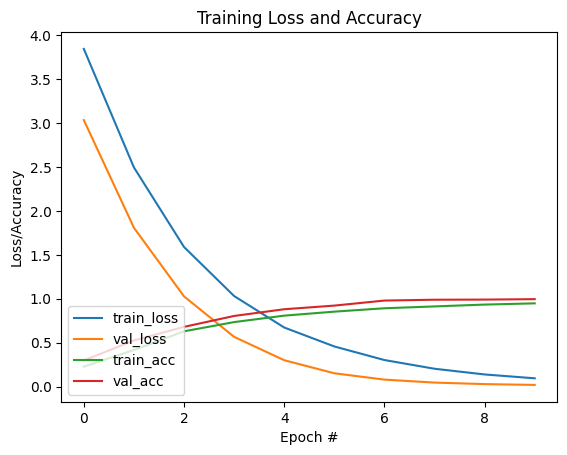

In [ ]:
# Linear model
wandb.init(project="simclr_ojus", id="train")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=10,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [ ]:
test_images = list(paths.list_images("/content/drive/MyDrive/Colab Notebooks/dataset_github用/test"))
X_test_new, y_test_new = prepare_images(test_images)
y_test_new_enc = le.transform(y_test_new)
test_features_new = projection.predict(X_test_new)
test_loss, test_accuracy = linear_model.evaluate(test_features_new, y_test_new_enc)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

100%|██████████| 708/708 [00:08<00:00, 81.76it/s]


(708, 224, 224, 3) (708,)
23/23 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.9986
Test Loss: 0.020399928092956543
Test Accuracy: 0.9985875487327576


In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

accuracy,▁▂▃▅▇▇█████████████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▆▇█████████████████████████████
val_loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,34
best_val_loss,0.01486
epoch,34
loss,0.00512
val_accuracy,1.0


Epoch 1/35
1/5 [=====>........................] - ETA: 2s - loss: 3.4945 - accuracy: 0.1875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 234ms/step - loss: 3.1100 - accuracy: 0.2622 - val_loss: 2.4597 - val_accuracy: 0.3150
Epoch 2/35
1/5 [=====>........................] - ETA: 0s - loss: 2.3644 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 220ms/step - loss: 1.8725 - accuracy: 0.4825 - val_loss: 1.3753 - val_accuracy: 0.4675
Epoch 3/35
1/5 [=====>........................] - ETA: 0s - loss: 1.4543 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 279ms/step - loss: 1.0648 - accuracy: 0.6678 - val_loss: 0.7121 - val_accuracy: 0.7331
Epoch 4/35
1/5 [=====>........................] - ETA: 0s - loss: 0.8008 - accuracy: 0.7344

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 545ms/step - loss: 0.6179 - accuracy: 0.7867 - val_loss: 0.3689 - val_accuracy: 0.8460
Epoch 5/35
1/5 [=====>........................] - ETA: 0s - loss: 0.4748 - accuracy: 0.7812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 289ms/step - loss: 0.3538 - accuracy: 0.8497 - val_loss: 0.2067 - val_accuracy: 0.9054
Epoch 6/35
1/5 [=====>........................] - ETA: 0s - loss: 0.3434 - accuracy: 0.8594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 407ms/step - loss: 0.2194 - accuracy: 0.9161 - val_loss: 0.1246 - val_accuracy: 0.9506
Epoch 7/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 290ms/step - loss: 0.1427 - accuracy: 0.9406 - val_loss: 0.0813 - val_accuracy: 0.9689
Epoch 8/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0788 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 218ms/step - loss: 0.1005 - accuracy: 0.9615 - val_loss: 0.0568 - val_accuracy: 0.9703
Epoch 9/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 198ms/step - loss: 0.0742 - accuracy: 0.9720 - val_loss: 0.0418 - val_accuracy: 0.9845
Epoch 10/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0443 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 354ms/step - loss: 0.0566 - accuracy: 0.9755 - val_loss: 0.0322 - val_accuracy: 0.9887
Epoch 11/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 205ms/step - loss: 0.0439 - accuracy: 0.9790 - val_loss: 0.0260 - val_accuracy: 0.9915
Epoch 12/35
1/5 [=====>........................] - ETA: 0s - loss: 0.1149 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 201ms/step - loss: 0.0361 - accuracy: 0.9860 - val_loss: 0.0216 - val_accuracy: 0.9972
Epoch 13/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0199 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 248ms/step - loss: 0.0289 - accuracy: 0.9895 - val_loss: 0.0187 - val_accuracy: 0.9972
Epoch 14/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0228 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 214ms/step - loss: 0.0246 - accuracy: 0.9895 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 15/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0224 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 212ms/step - loss: 0.0211 - accuracy: 0.9895 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 16/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 217ms/step - loss: 0.0182 - accuracy: 0.9930 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 17/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0116 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 228ms/step - loss: 0.0163 - accuracy: 0.9965 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 18/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 1s 351ms/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 19/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 390ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 20/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 302ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 21/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 285ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 22/35
5/5 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 294ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 23/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 205ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 24/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 213ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 25/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 251ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 26/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 206ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 27/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 231ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 28/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 230ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 29/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 195ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 30/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 211ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 31/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 244ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 32/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 219ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 33/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 1s 298ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 34/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 317ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 35/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095257-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 274ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000


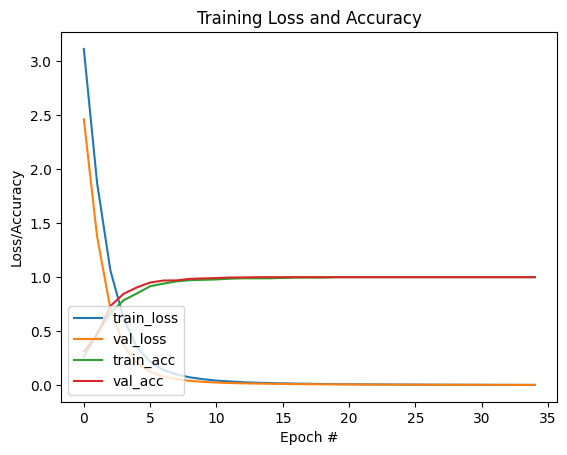

In [ ]:
# Linear model
wandb.init(project="simclr_ojus", id="train")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [ ]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

23/23 [==============================] - 1s 31ms/step
(286, 256) (708, 256)


accuracy,▁▃▅▆▇▇▇████████████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇█████████████████████████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,34
best_val_loss,0.00421
epoch,34
loss,0.00402
val_accuracy,1.0


Epoch 1/35
1/5 [=====>........................] - ETA: 2s - loss: 7.9208 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 255ms/step - loss: 7.1263 - accuracy: 0.0909 - val_loss: 8.0878 - val_accuracy: 0.0621
Epoch 2/35
1/5 [=====>........................] - ETA: 0s - loss: 4.8845 - accuracy: 0.2188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 238ms/step - loss: 4.1609 - accuracy: 0.2937 - val_loss: 4.9440 - val_accuracy: 0.1709
Epoch 3/35
1/5 [=====>........................] - ETA: 0s - loss: 2.3672 - accuracy: 0.5156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 254ms/step - loss: 2.0676 - accuracy: 0.5175 - val_loss: 2.5468 - val_accuracy: 0.3602
Epoch 4/35
1/5 [=====>........................] - ETA: 0s - loss: 1.3090 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 219ms/step - loss: 0.8144 - accuracy: 0.6888 - val_loss: 0.9624 - val_accuracy: 0.5579
Epoch 5/35
1/5 [=====>........................] - ETA: 0s - loss: 0.2967 - accuracy: 0.8125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 252ms/step - loss: 0.1850 - accuracy: 0.9091 - val_loss: 0.2439 - val_accuracy: 0.8573
Epoch 6/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0632 - accuracy: 0.9844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 238ms/step - loss: 0.0372 - accuracy: 0.9930 - val_loss: 0.0594 - val_accuracy: 1.0000
Epoch 7/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 215ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 8/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 223ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 9/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 283ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 10/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 397ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 11/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 280ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 12/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 349ms/step - loss: 9.4930e-04 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 13/35
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 246ms/step - loss: 8.5246e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 14/35
1/5 [=====>........................] - ETA: 0s - loss: 9.6592e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 211ms/step - loss: 8.0211e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 15/35
1/5 [=====>........................] - ETA: 0s - loss: 8.4881e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 228ms/step - loss: 7.6702e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 16/35
1/5 [=====>........................] - ETA: 0s - loss: 7.6491e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 244ms/step - loss: 7.4523e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 17/35
1/5 [=====>........................] - ETA: 0s - loss: 7.0059e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 213ms/step - loss: 7.2780e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 18/35
1/5 [=====>........................] - ETA: 0s - loss: 7.6845e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 253ms/step - loss: 7.1628e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 19/35
1/5 [=====>........................] - ETA: 0s - loss: 5.5986e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 203ms/step - loss: 7.0644e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 20/35
1/5 [=====>........................] - ETA: 0s - loss: 6.7097e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 347ms/step - loss: 6.9785e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 21/35
1/5 [=====>........................] - ETA: 0s - loss: 7.5108e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 214ms/step - loss: 6.8994e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 22/35
1/5 [=====>........................] - ETA: 0s - loss: 7.2556e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 238ms/step - loss: 6.8268e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 23/35
1/5 [=====>........................] - ETA: 0s - loss: 4.6658e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 233ms/step - loss: 6.7519e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 24/35
4/5 [=======================>......] - ETA: 0s - loss: 6.6977e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 2s 379ms/step - loss: 6.6855e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 25/35
1/5 [=====>........................] - ETA: 0s - loss: 5.9766e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 2s 399ms/step - loss: 6.6147e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 26/35
1/5 [=====>........................] - ETA: 0s - loss: 6.0630e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.1s


5/5 [==============================] - 3s 847ms/step - loss: 6.5478e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 27/35
1/5 [=====>........................] - ETA: 0s - loss: 5.8117e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 269ms/step - loss: 6.4772e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 28/35
1/5 [=====>........................] - ETA: 0s - loss: 5.6630e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 210ms/step - loss: 6.4115e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 29/35
1/5 [=====>........................] - ETA: 0s - loss: 6.3351e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 217ms/step - loss: 6.3442e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 30/35
1/5 [=====>........................] - ETA: 0s - loss: 5.0722e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 231ms/step - loss: 6.2763e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 31/35
1/5 [=====>........................] - ETA: 0s - loss: 7.3773e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 230ms/step - loss: 6.2118e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 32/35
1/5 [=====>........................] - ETA: 0s - loss: 7.6845e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 208ms/step - loss: 6.1432e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 33/35
1/5 [=====>........................] - ETA: 0s - loss: 4.7755e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 220ms/step - loss: 6.0760e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 34/35
1/5 [=====>........................] - ETA: 0s - loss: 5.7840e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 228ms/step - loss: 6.0109e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 35/35
1/5 [=====>........................] - ETA: 0s - loss: 5.7519e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095437-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 211ms/step - loss: 5.9470e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000


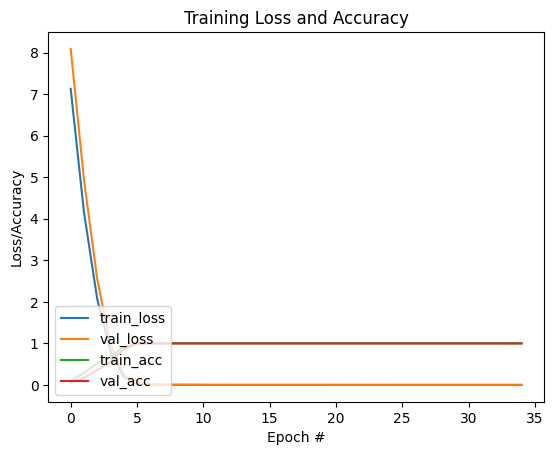

In [ ]:
wandb.init(project="simclr_ojus", id="train")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [ ]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

23/23 [==============================] - 1s 41ms/step
(286, 2048) (708, 2048)


accuracy,▁▃▄▆▇██████████████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▅▇██████████████████████████████
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
best_epoch,34
best_val_loss,0.00254
epoch,34
loss,0.00059
val_accuracy,1.0


Epoch 1/35
1/5 [=====>........................] - ETA: 2s - loss: 3.1315 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095556-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 2s 248ms/step - loss: 0.7787 - accuracy: 0.7692 - val_loss: 1.1501e-05 - val_accuracy: 1.0000
Epoch 2/35
1/5 [=====>........................] - ETA: 0s - loss: 1.6983e-05 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/drive/MyDrive/Colab Notebooks/wandb/run-20240116_095556-train/files/model-best)... Done. 0.0s


5/5 [==============================] - 1s 260ms/step - loss: 4.5115e-06 - accuracy: 1.0000 - val_loss: 7.9136e-09 - val_accuracy: 1.0000
Epoch 3/35
5/5 [==============================] - 0s 55ms/step - loss: 7.9195e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/35
5/5 [==============================] - 1s 123ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/35
5/5 [==============================] - 0s 84ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5: early stopping


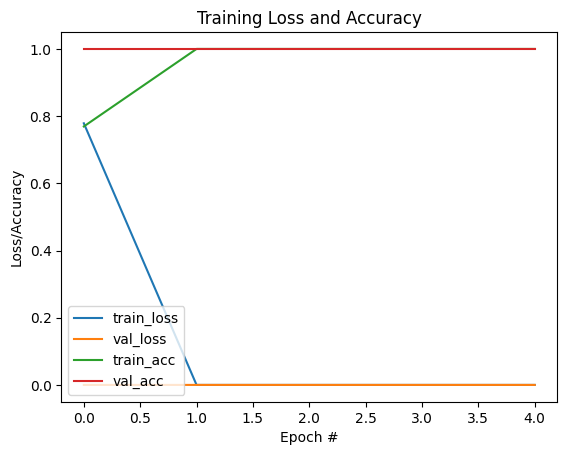

In [ ]:
wandb.init(project="simclr_ojus", id="train")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

## Visualization of the representations

In [ ]:
wandb.init(project="boar_simclr", id="subset")

accuracy,▁█████
epoch,▁▂▄▅▇█
loss,█▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁
accuracy,1.0
epoch,5
loss,0.0
val_accuracy,1.0
val_loss,0.0


In [ ]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

In [ ]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

4/4 [==============================] - 1s 102ms/step


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})

4/4 [==============================] - 1s 113ms/step


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 3 keyword-only arguments) were given

<Figure size 1000x1000 with 0 Axes>